In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

%matplotlib notebook

In [2]:
# total_tweets is I
# user_followers_count is S

# Read first 400 timestamps
df = pd.read_csv('data/timeseries/Verified/TRUMP_CHANTING_VERIFIED.csv')
df = df[:400]

yData = np.cumsum(df['total_tweets'])
xData = np.arange(0, len(df), 1)

# Time span for the solve_ivp function
tSpan = [0, len(df)]

# Initial infections at the start
I0 = yData[0]

------------ Parameters -------------
S0 = 29041.277086795584
E0 = 49.61690903304351
Z0 = 1381.3925446910896
beta = 0.00010059738438353401
b = 0.2195722227892618
ro = 0.27606409793853043
p = 0.010185780850298937
e = 0.11377095812187245
l = 1.079793787102897e-09


<IPython.core.display.Javascript object>


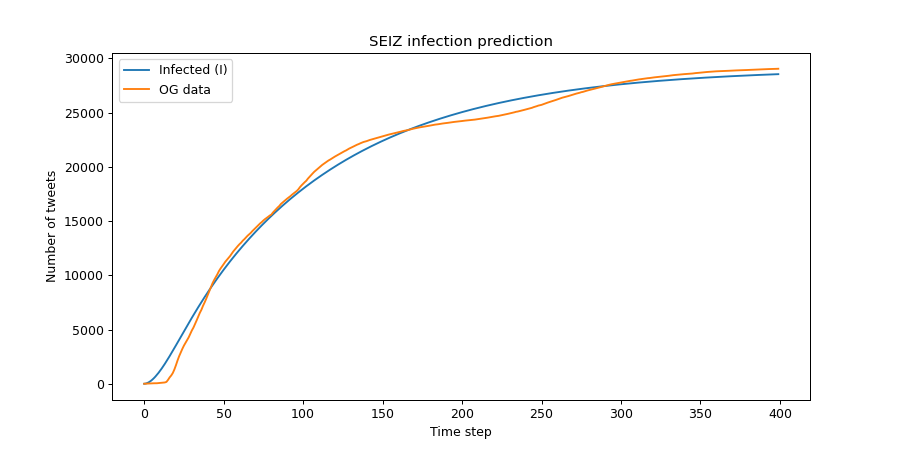

<IPython.core.display.Javascript object>


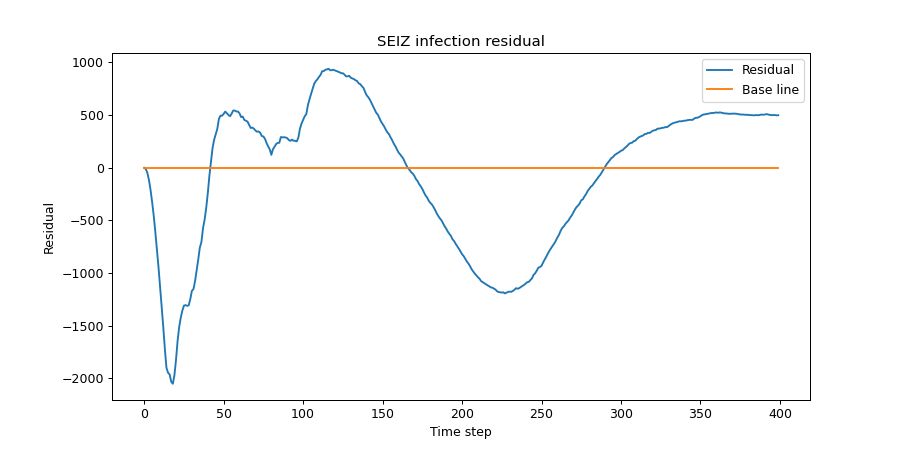

<IPython.core.display.Javascript object>


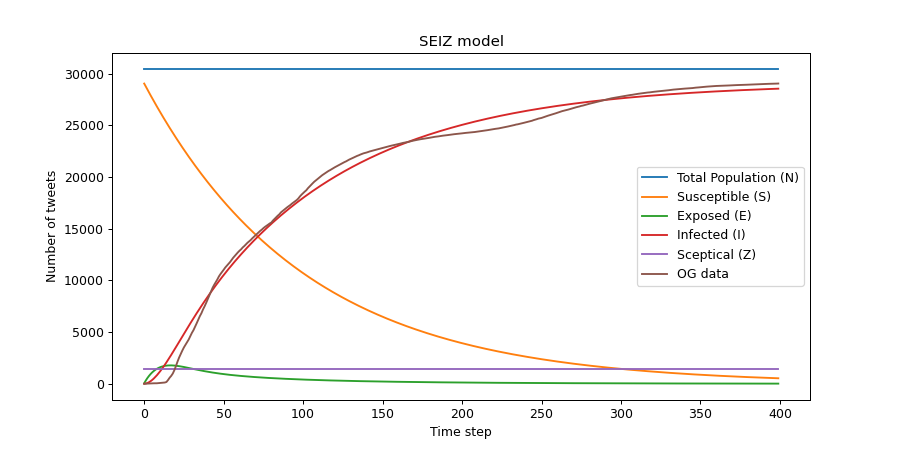

0.00010059738438353401


In [138]:
# Run this for the SEIZ model

# Function for SEIZ system of ODEs
# S0, E0, Z0, beta, b, ro, p, e and l are unknown
def seiz(t, y, S0, E0, Z0, beta, b, ro, p, e, l):
    S = y[0]
    E = y[1]
    I = y[2]
    Z = y[3]
    
    N = S0 + E0 + I0 + Z0
    
    dS = -1 * beta * S * (I / N) - b * S * (Z / N)
    dE = (1 - p) * beta * S * (I / N) + (1 - l) * b * S * (Z / N) - ro * E * (I / N) - e * E
    dI = p * beta * S * (I / N) + ro * E * (I / N) + e * E
    dZ = l * b * S * (Z / N)

#     dS = -1 * beta * S * (I / 1) - b * S * (Z / 1)
#     dE = (1 - p) * beta * S * (I / 1) + (1 - l) * b * S * (Z / 1) - ro * E * (I / 1) - e * E
#     dI = p * beta * S * (I / 1) + ro * E * (I / 1) + e * E
#     dZ = l * b * S * (Z / 1)

    return [dS, dE, dI, dZ]

def solve_seiz(x, *args):
    initialValues = [args[0], args[1], I0, args[2]] # [S0, E0, I0, Z0]
    
    return solve_ivp(seiz, tSpan, initialValues, method='BDF', t_eval=x, args=args).y

def fit_seiz(x, *args):
    # Return the solution for the infections which we can then compare to the OG data
    return solve_seiz(x, *args)[2]

initial_guess = [100, 100, 100, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10]
bounds = (0, [9e8, 9e8, 9e8, 100, 100, 100, 1, 100, 1]) # All changing parameters should theoretically be between [0, 1]

popt, pcov = curve_fit(fit_seiz, xData, yData, initial_guess, bounds=bounds)

print('------------ Parameters -------------')
print(f'S0 = {popt[0]}')
print(f'E0 = {popt[1]}')
print(f'Z0 = {popt[2]}')
print(f'beta = {popt[3]}')
print(f'b = {popt[4]}')
print(f'ro = {popt[5]}')
print(f'p = {popt[6]}')
print(f'e = {popt[7]}')
print(f'l = {popt[8]}')

# Fitted SEIZ model with the guessed args
fitted = solve_seiz(xData, *popt)

infected_residuals = yData - fitted[2]

# Plotting

# Prediction accuracy
plt.figure(figsize=(10, 5))
plt.title('SEIZ infection prediction')

plt.plot(fitted[2], label='Infected (I)')
plt.plot(yData, label='OG data')

plt.xlabel('Time step')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('seiz_prediction.png')

plt.show()

# Infection residual
plt.figure(figsize=(10, 5))
plt.title('SEIZ infection residual')

plt.plot(infected_residuals, label='Residual')
plt.plot([0] * len(df), label='Base line')

plt.xlabel('Time step')
plt.ylabel('Residual')

plt.legend()

plt.savefig('seiz_residual.png')

plt.show()

# Whole SEIZ model
plt.figure(figsize=(10, 5))
plt.title('SEIZ model')

N = popt[0] + popt[1] + I0 + popt[2]

plt.plot([N] * len(df), label='Total Population (N)')
plt.plot(fitted[0], label='Susceptible (S)')
plt.plot(fitted[1], label='Exposed (E)')
plt.plot(fitted[2], label='Infected (I)')
plt.plot(fitted[3], label='Sceptical (Z)')

plt.plot(yData, label='OG data')

plt.xlabel('Time step')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('seiz_model.png')

plt.show()

S0 = popt[0]
E0 = popt[1]
Z0 = popt[2]

beta = popt[3]
b = popt[4]
ro = popt[5]
p = popt[6]
e = popt[7]
l = popt[8]


# beta = beta / (N / 10)
# b = b / (N / 10) 
# ro = ro / (N / 10)

print(beta)

In [139]:
# Run this to divide by k

k = (np.array(in_degrees).sum() + np.array(out_degrees).sum()) / N

beta = beta / k
b = b / k
ro = ro / k
print(beta)

3.6791281331300555e-06


In [140]:
# Networking
import networkx as nx

27.34272380395454


In [128]:
# Power Law distribution
degrees = []

in_degrees = []
out_degrees = []

for i in range(round(N)):
    n = np.random.uniform(0, 316*1e6) # Random number (rank of twitter user)
    
    degrees.append(round(1e6*((1 / n)**0.62)))
#     degrees.append(round(4))

in_degrees = random.sample(degrees, len(degrees))
out_degrees = random.sample(degrees, len(degrees))

print(np.array(degrees).max())

1410


In [143]:
G = nx.directed_configuration_model(in_degrees, out_degrees)
G.remove_edges_from(nx.selfloop_edges(G))

<IPython.core.display.Javascript object>


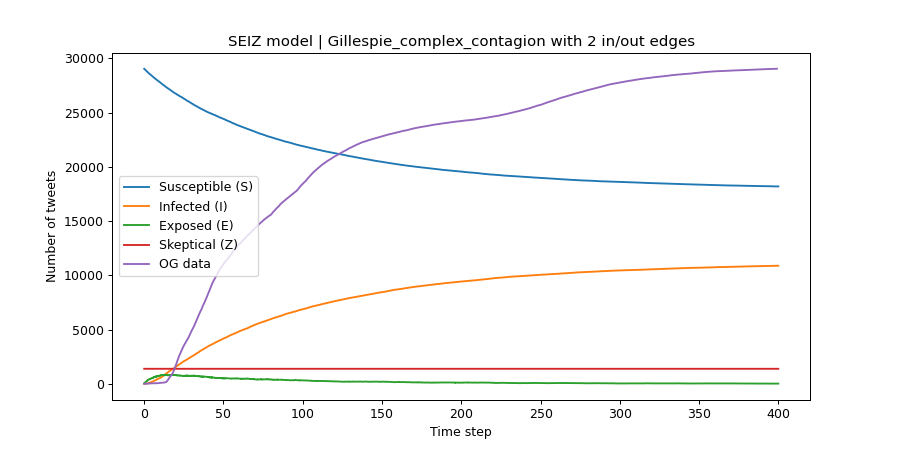

In [144]:
import EoN
import matplotlib.pyplot as plt
from collections import defaultdict #makes defining the initial condition easier
import random
from networkx.drawing.nx_pydot import graphviz_layout


def rate_function(G, node, status, parameters):
    # This function needs to return the rate at which node changes status.
    
    beta, b, ro, p, e, l = parameters
    
    if status[node] == 'E':
        infected_neighbours = len([nbr for nbr in G.neighbors(node) if status[nbr] == 'I'])
        rate_of_infection = ro * infected_neighbours
        
        return e + rate_of_infection
    
    elif status[node] == 'S':
        infected_neighbours = len([nbr for nbr in G.neighbors(node) if status[nbr] == 'I'])
        rate_of_infection = beta * infected_neighbours
        
        skeptical_neighbours = len([nbr for nbr in G.neighbors(node) if status[nbr] == 'Z'])
        rate_of_skeptisim = b * skeptical_neighbours
#         print(rate_of_skeptisim + rate_of_infection)
        return rate_of_skeptisim + rate_of_infection
    else:
        return 0

def transition_choice(G, node, status, parameters):
    #this function needs to return the new status of node.  We already
    #know it is changing status.
    #
    #this function could be more elaborate if there were different
    #possible transitions that could happen.
    
    beta, b, ro, p, e, l = parameters
        
    if status[node] == 'E':
        return 'I'
    elif status[node] == 'S':
        infected_neighbours = len([nbr for nbr in G.neighbors(node) if status[nbr] == 'I'])
        rate_of_infection = 1 - (1 - beta)**infected_neighbours
        
        skeptical_neighbours = len([nbr for nbr in G.neighbors(node) if status[nbr] == 'Z'])
        rate_of_skeptisim = 1 - (1 - b)**skeptical_neighbours
        
#         print(rate_of_skeptisim)
        probI = rate_of_infection
        probZ = rate_of_skeptisim
        
        if (probI == 0):
            return np.random.choice(['E', 'Z'], p=[1 - l, l])
        elif (probZ == 0):
            return np.random.choice(['I', 'E'], p=[p, 1 - p])

        scaler = (1 / probI) / (1 / probZ)

        probX = 1 / (1 + scaler)

        probY = probX * scaler
        
        
        if np.random.choice(['I', 'Z'], p=[probX, probY]) == 'I':
            return np.random.choice(['I', 'E'], p=[p, 1 - p])
        else:
            return np.random.choice(['E', 'Z'], p=[1 - l, l])

def get_influence_set(G, node, status, parameters):
    #this function needs to return any node whose rates might change
    #because ``node`` has just changed status.
    #
    #the only neighbors a node might affect are the susceptible ones.

#     return {nbr for nbr in G.neighbors(node) if status[nbr] == 'S'}

    return G.predecessors(node) # predecessors

# S0 = 26075
# E0 = 3697
# Z0 = 4960
# I0 = I0

# RR = E0 + I0 + Z0

# beta = 0.00010424525783735672
# b = 0.061676862047482
# ro = 0.17296291342110615
# p = 0.032964728489218095
# e = 0.02965275728725226
# l = 0.024327454154160776

# S0 = 20996.33080995184
# E0 = 7270.397490027181
# Z0 = 650.9656814714043
# I0 = I0

# RR = E0 + I0 + Z0

# beta = 0.017525945885466056
# b = 0.004660032336795342
# ro = 0.05139339599138839
# p = 0.013571489539109607
# e = 0.20863753805714338
# l = 0.15912992367485299



parameters = (beta, b, ro, p, e, l)

IC = defaultdict(lambda: 'S')

for node in range(round(E0)):
    IC[node] = 'E'
    
for node in range(round(I0)):
    IC[node + round(E0)] = 'I'

for node in range(round(Z0)):
    IC[node + round(E0 + I0)] = 'Z'

color_dict = {'S': '#009a80','E': 'blue', 'I':'#ff2000', 'Z':'gray'}
pos = {node:node for node in G}
tex = True
sim_kwargs = {'color_dict':color_dict, 'tex':tex}

# sim = EoN.Gillespie_complex_contagion(G, rate_function,
#                            transition_choice, get_influence_set, IC,
#                            return_statuses=('S', 'E', 'I', 'Z'),
#                            parameters=parameters, return_full_data=True, sim_kwargs=sim_kwargs, tmax=400)

# times, D = sim.summary()

# sim.display(0, node_size = 1, ts_plots=['S', 'E', 'I', 'Z'], nodelist = [], with_labels=True)

t, S, E, I, Z = EoN.Gillespie_complex_contagion(G, rate_function,
                           transition_choice, get_influence_set, IC,
                           return_statuses=('S', 'E', 'I', 'Z'),
                           parameters=parameters, tmax=400)


# plt.savefig('SIRV_display.png')

# from matplotlib import animation

# https://github.com/kkroening/ffmpeg-python/issues/251#issuecomment-520944849
# writergif = animation.FFMpegWriter(fps=5)

# ani=sim.animate(ts_plots=['S', 'E', 'I', 'Z'], node_size = 100)
# ani.save('SIRV_animate.mp4', writer=writergif)

# plt.figure(figsize=(10, 5))
# plt.plot(t, I)

# plt.show()



plt.figure(figsize=(10, 5))
plt.title('SEIZ model | Gillespie_complex_contagion with 2 in/out edges')

# N = popt[0] + popt[1] + I0 + popt[2]

# plt.plot([N] * len(df), label='Total Population (N)')
plt.plot(t, S, label='Susceptible (S)')
# plt.plot(EE, label='Exposed (E)')
plt.plot(t, I, label='Infected (I)')
plt.plot(t, E, label='Exposed (E)')
plt.plot(t, Z, label='Skeptical (Z)')
# plt.plot(ZZ, label='Sceptical (Z)')

plt.plot(yData, label='OG data')

plt.xlabel('Time step')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('seiz_model.png')

plt.show()

# CODE NOT RELAVANT BELOW

<IPython.core.display.Javascript object>


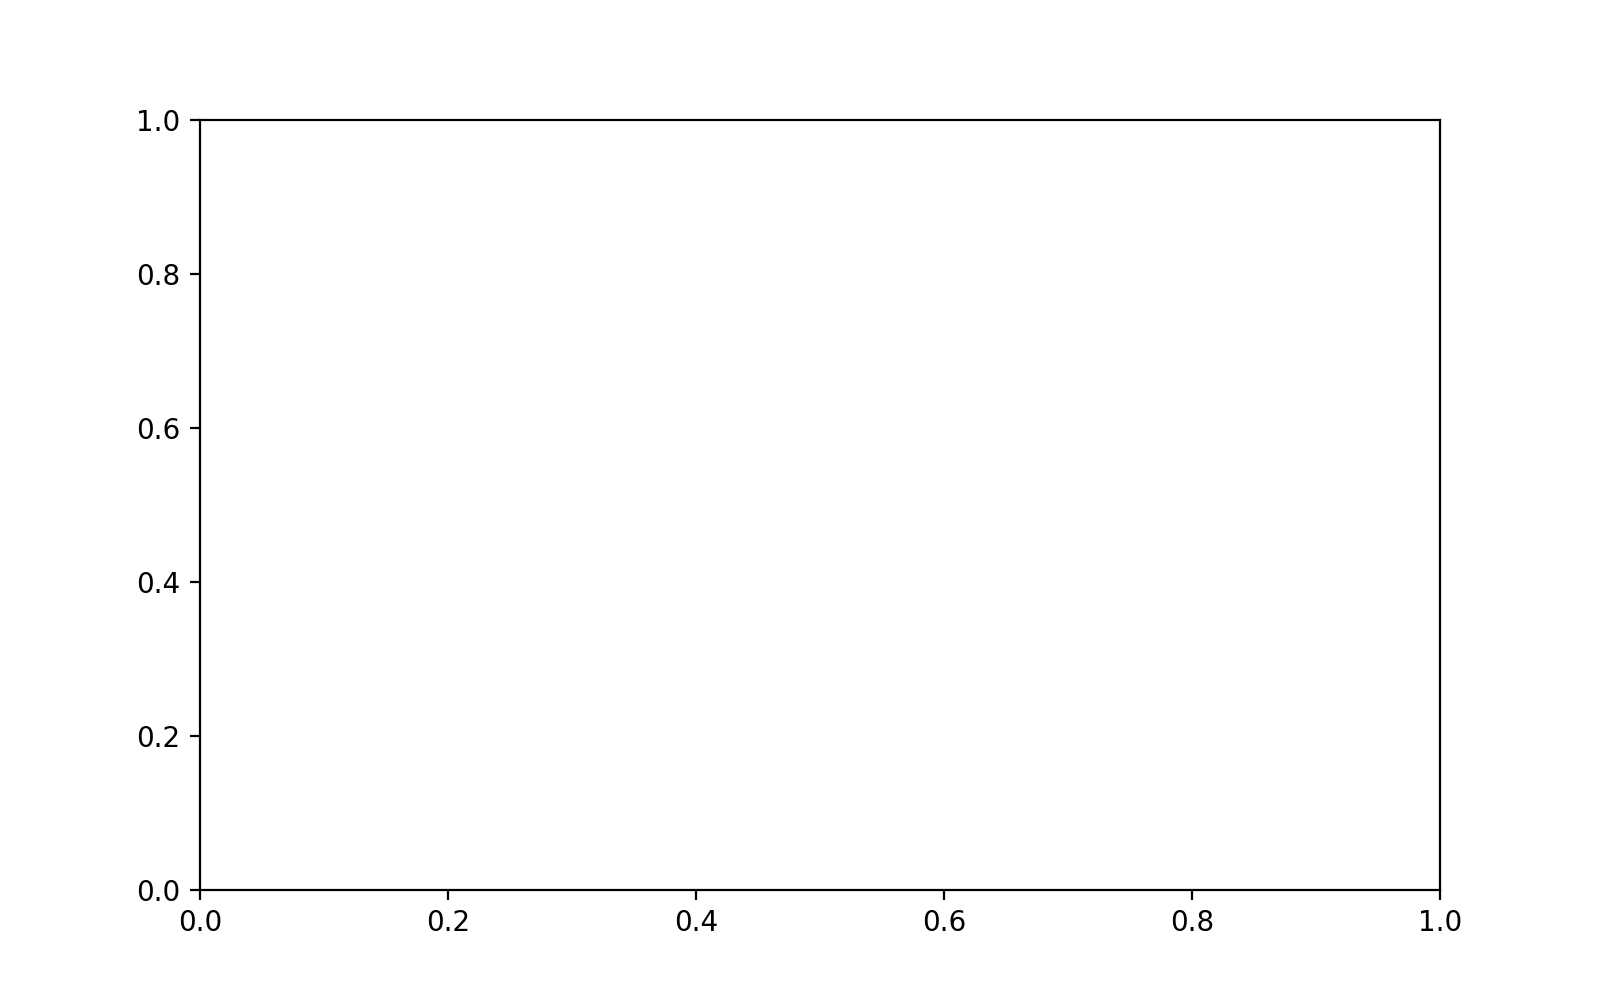

ImportError: requires pygraphviz http://pygraphviz.github.io/

In [139]:
# nx.draw_networkx_edges(G, pos=nx.spring_layout(G))

plt.figure(figsize=(8,5))
ax = plt.gca()
nx.draw_networkx_edges(G, pos=nx.nx_agraph.graphviz_layout(G), arrows=True, arrowstyle='->', 
                       edge_color='green', width=2, ax=ax)
nx.draw_networkx_nodes(G, pos=nx.nx_agraph.graphviz_layout(G), node_color='orange')
nx.draw_networkx_labels(G, pos=nx.nx_agraph.graphviz_layout(G))
plt.box(False)

In [160]:
G[0][19][0].status

AttributeError: 'dict' object has no attribute 'status'

In [178]:
IC

defaultdict(<function __main__.<lambda>()>,
            {18: 'I',
             13: 'I',
             12: 'I',
             0: 'S',
             1: 'S',
             2: 'S',
             3: 'S',
             4: 'S',
             5: 'S',
             6: 'S',
             7: 'S',
             8: 'S',
             9: 'S',
             10: 'S',
             11: 'S',
             14: 'S',
             15: 'S',
             16: 'S',
             17: 'S',
             19: 'S'})

In [176]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [196]:
nx.draw(G)

In [190]:
D

{'S': array([17, 16, 16, 16, 16, 16, 15, 15, 14, 14, 13, 13]),
 'I': array([3, 4, 3, 2, 1, 0, 1, 0, 1, 0, 1, 0]),
 'R': array([0, 0, 1, 2, 3, 4, 4, 5, 5, 6, 6, 7])}

In [29]:
np.random.choice(['I', 'Z'], p=[0.1, 0.9])

'Z'

In [40]:
probI = 0.00010424525783735672
probZ = 0.061676862047482

scaler = (1 / probI) / (1 / probZ)

probX = 1 / (1 + scaler)

probY = probX * scaler

print(probX, probY)

0.0016873322992121441 0.998312667700788


In [52]:
# for node in random.choices(list(range(20)), k=3):
#     IC[node] = 'I'
IC

while 

defaultdict(<function __main__.<lambda>()>,
            {14: 'Z',
             8: 'Z',
             0: 'S',
             1: 'S',
             2: 'S',
             3: 'S',
             4: 'S',
             5: 'S',
             6: 'S',
             7: 'S',
             9: 'S',
             10: 'S',
             11: 'S',
             12: 'S',
             13: 'S',
             15: 'S',
             16: 'S',
             17: 'S',
             18: 'S',
             19: 'S'})

In [12]:
seq = nx.utils.powerlaw_sequence(2000000, -2.1715)

np.array([10e7 * a for a in seq]).average()

AttributeError: 'numpy.ndarray' object has no attribute 'average'

In [14]:
from scipy.stats import powerlaw

powerlaw.rvs(2, loc = 2, scale = 13, size = 1000)

array([12.49560175, 14.96890513, 14.14080557, 12.87509135,  7.46613868,
       12.595235  , 11.21313411, 13.57695723, 13.75909072, 14.1998628 ,
       14.67081115,  7.25486373, 12.43405146, 10.87575823, 10.49494343,
       10.18984258,  7.14222945, 13.89000397, 12.17749874, 14.42307767,
        8.49056637, 14.05195745, 12.49887286, 13.03878897,  9.67300125,
       13.13656383,  7.35544434, 13.56995378,  5.70474908, 11.89079423,
       14.14393884, 14.78804439,  6.31799618, 13.38568023,  9.21110349,
        9.43105915,  7.20694097, 14.27653829, 10.5483566 , 14.68286836,
       13.0358678 ,  2.90534671, 10.64740409,  9.03268047, 10.54387692,
       13.62388761, 11.95036956, 10.7274711 ,  7.6226883 ,  3.80677405,
       12.12416195, 13.16790718, 13.97075019,  7.17234951, 13.23390971,
        9.81045935, 14.79592853, 12.60652657,  3.67790655, 14.46928094,
        9.81740609, 12.95053089, 14.24956082, 10.01940022, 10.44832678,
        9.47530398, 13.25852594, 13.01558277,  5.98399258, 14.76

In [104]:
a = np.random.power(2.1715, (1, 40000))

a = [(b * 10e6) for b in a]

np.array(a).min()

63891.04571734673

<IPython.core.display.Javascript object>


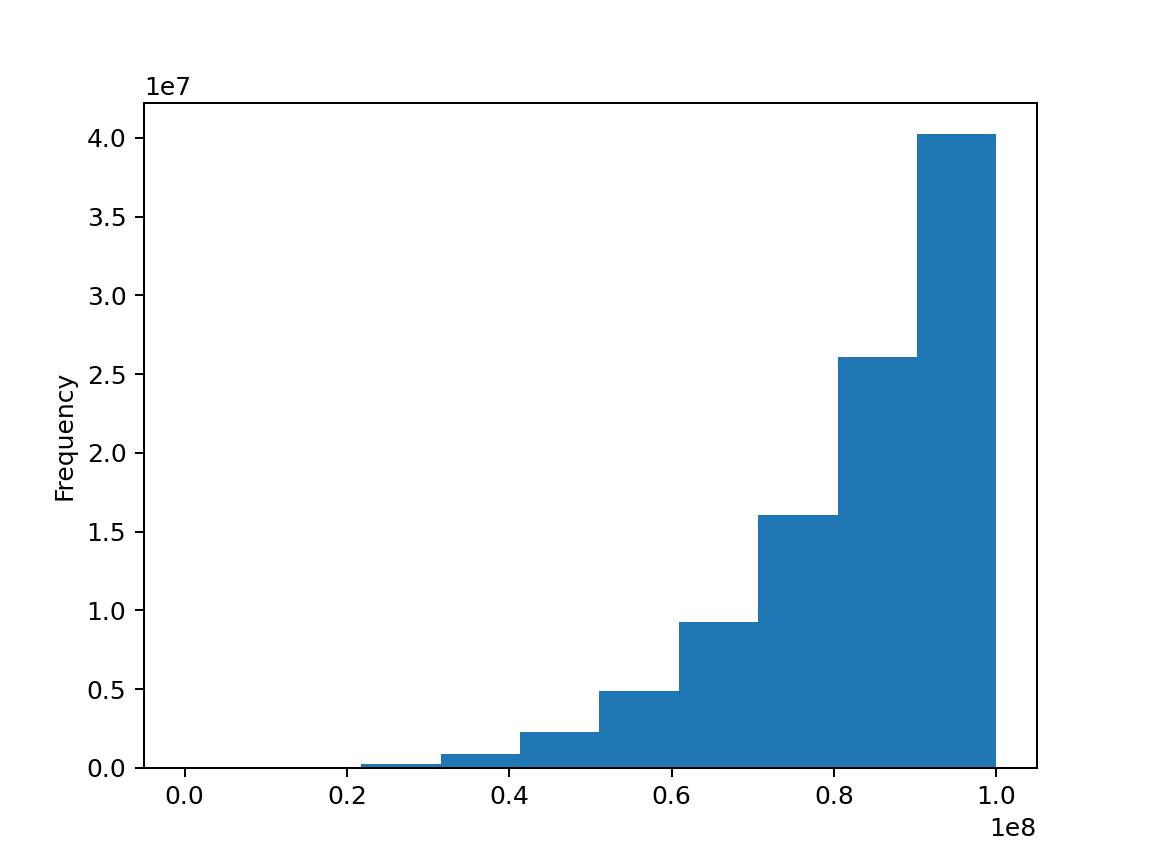

<AxesSubplot:ylabel='Frequency'>

In [64]:
# pd.Series(a[0]).plot.hist(orientation='horizontal')
pd.Series(a[0]).plot.hist()

In [27]:
a

[array([0.96065762, 0.9253234 , 0.56760109, ..., 0.628092  , 0.63655712,
        0.12284189])]

In [41]:
a[0][0]

0.02434204374635559

In [20]:
a

[array([55779557.55365243, 79902742.55994591, 80919348.26218805, ...,
        39072697.73555983, 85868082.94534034, 76720221.65760095])]

15698877.222039668

In [101]:
c = [10e15 * ((b)**(-2.1715)) for b in a]

In [102]:
np.array(c).max()

1913604.4443973931

In [103]:
c

[array([54.47533989,  8.91149816,  8.40725842, ..., 39.25053162,
         7.14627316, 24.43750666])]

<IPython.core.display.Javascript object>


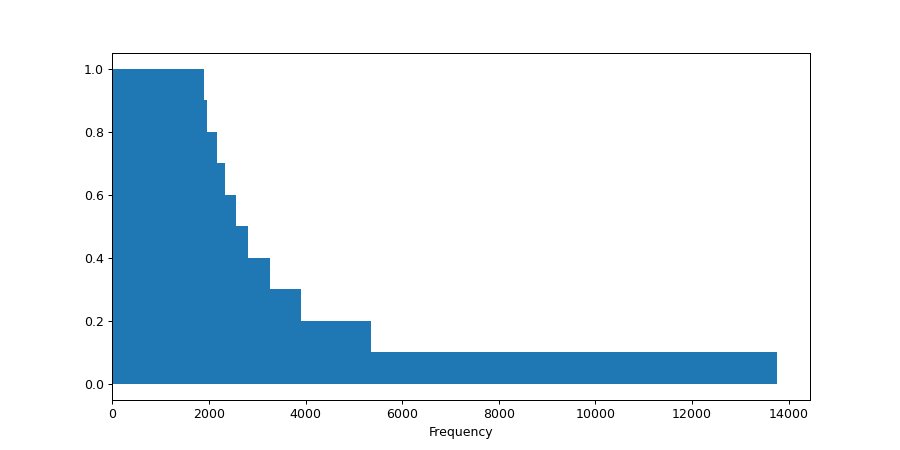

In [112]:
dd = np.random.power(1/2.1715, (1, 40000))

plt.figure(figsize=(10, 5))
pd.Series(dd[0]).plot.hist(orientation='horizontal')

plt.show()

In [128]:
np.random.uniform(0, 316*1e6)

165941346.91116887

In [119]:
1e6

1000000.0

In [150]:
rr = []

for i in range(40000):
    rr.append(np.random.uniform(0, 316*1e6))

In [133]:
np.array(rr).min()

5999.375116872318

In [8]:
np.array(degrees).max()

17721

In [153]:
degrees

[78,
 69,
 96,
 66,
 133,
 135,
 147,
 54,
 83,
 81,
 230,
 56,
 130,
 60,
 169,
 103,
 173,
 79,
 84,
 139,
 84,
 101,
 95,
 109,
 293,
 64,
 63,
 60,
 163,
 112,
 65,
 72,
 119,
 67,
 73,
 94,
 62,
 63,
 67,
 137,
 54,
 92,
 56,
 56,
 71,
 56,
 71,
 65,
 118,
 58,
 66,
 113,
 76,
 137,
 67,
 180,
 93,
 70,
 79,
 74,
 80,
 59,
 73,
 318,
 86,
 92,
 66,
 94,
 69,
 76,
 108,
 67,
 62,
 77,
 201,
 130,
 359,
 85,
 141,
 120,
 276,
 167,
 61,
 62,
 55,
 72,
 101,
 124,
 69,
 379,
 83,
 76,
 72,
 68,
 386,
 90,
 77,
 57,
 58,
 106,
 80,
 166,
 103,
 111,
 60,
 76,
 73,
 567,
 59,
 108,
 132,
 97,
 57,
 70,
 168,
 85,
 89,
 91,
 82,
 116,
 105,
 61,
 89,
 74,
 163,
 110,
 91,
 67,
 55,
 74,
 238,
 58,
 56,
 82,
 106,
 523,
 103,
 130,
 396,
 69,
 105,
 66,
 61,
 62,
 71,
 112,
 54,
 67,
 172,
 98,
 57,
 66,
 91,
 58,
 55,
 57,
 157,
 57,
 77,
 108,
 102,
 72,
 85,
 75,
 85,
 101,
 15629,
 702,
 533,
 293,
 278,
 58,
 75,
 63,
 130,
 61,
 69,
 104,
 67,
 114,
 76,
 179,
 192,
 92,
 146,
 60,

In [7]:
N

28919.693981450426

In [158]:
for i in range(len(degrees)):
    if (degrees[i] == np.array(degrees).max()):
        print(i)

4665


In [14]:
G[4665]

AdjacencyView({24965: {0: {}}, 250: {0: {}}, 21023: {0: {}}, 27293: {0: {}}, 26423: {0: {}}, 4499: {0: {}}, 8847: {0: {}}, 5103: {0: {}}, 28110: {0: {}}, 6610: {0: {}}, 708: {0: {}}, 22344: {0: {}}, 12849: {0: {}}, 4404: {0: {}}, 19225: {0: {}}, 3513: {0: {}}, 1440: {0: {}}, 2815: {0: {}}, 27457: {0: {}}, 23107: {0: {}}, 12296: {0: {}}, 28397: {0: {}}, 22499: {0: {}}, 14940: {0: {}}, 14413: {0: {}}, 8958: {0: {}}, 5125: {0: {}}, 7861: {0: {}}, 25694: {0: {}}, 12262: {0: {}}, 10141: {0: {}}, 28395: {0: {}}, 24877: {0: {}}, 20910: {0: {}}, 26963: {0: {}}, 20148: {0: {}}, 10351: {0: {}}, 17340: {0: {}}, 22460: {0: {}}, 6973: {0: {}}, 7772: {0: {}}, 17953: {0: {}}, 3866: {0: {}}, 4579: {0: {}}, 9816: {0: {}}, 28840: {0: {}}, 12319: {0: {}}, 2392: {0: {}}, 12112: {0: {}}, 23196: {0: {}}, 24904: {0: {}}, 20763: {0: {}}, 12468: {0: {}}, 27150: {0: {}}, 22007: {0: {}}, 13340: {0: {}}, 21790: {0: {}}, 14691: {0: {}}, 19129: {0: {}}})

In [10]:
G.degree[1]

114

In [ ]:
nx.draw(G)

In [ ]:
pos = nx.spring_layout(G)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

In [12]:
nx.write_gexf(G, "test.gexf")

In [13]:
N

28919.693981450426

In [16]:
D

{'S': array([28911, 28910, 28909, ...,  2886,  2885,  2885]),
 'E': array([ 0,  1,  2, ..., 18, 19, 18]),
 'I': array([    3,     3,     3, ..., 25467, 25467, 25468]),
 'Z': array([  6,   6,   6, ..., 549, 549, 549])}

In [18]:
SS = D['S']
EE = D['E']
II = D['I']
ZZ = D['Z']

array([    3,     3,     3, ..., 25467, 25467, 25468])

In [19]:
yData

0          2.0
1         11.0
2         24.0
3         31.0
4         35.0
        ...   
395    29023.0
396    29030.0
397    29035.0
398    29038.0
399    29045.0
Name: total_tweets, Length: 400, dtype: float64

<IPython.core.display.Javascript object>


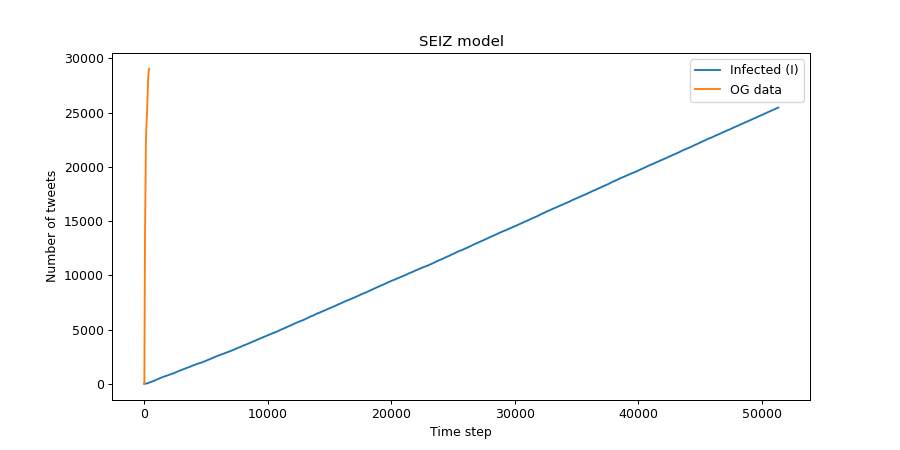

In [38]:
plt.figure(figsize=(10, 5))
plt.title('SEIZ model')

# N = popt[0] + popt[1] + I0 + popt[2]

# plt.plot([N] * len(df), label='Total Population (N)')
# plt.plot(SS, label='Susceptible (S)')
# plt.plot(EE, label='Exposed (E)')
plt.plot(II, label='Infected (I)')
# plt.plot(ZZ, label='Sceptical (Z)')

plt.plot(yData, label='OG data')

plt.xlabel('Time step')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('seiz_model.png')

plt.show()

In [24]:
N

28919.693981450426

In [26]:
I0 + E0 + Z0

8659.0

In [30]:
len(times)

45594

In [31]:
N = 50
I0 = 10
E0 = 15
Z0 = 5
S0 = 20

In [41]:
t # PUSH IT

array([0.        , 4.42903991, 8.6315523 , 8.65104077])

In [58]:
len(t)

11842

In [47]:
len(I)

18

2.6276652518543264e-06


<IPython.core.display.Javascript object>


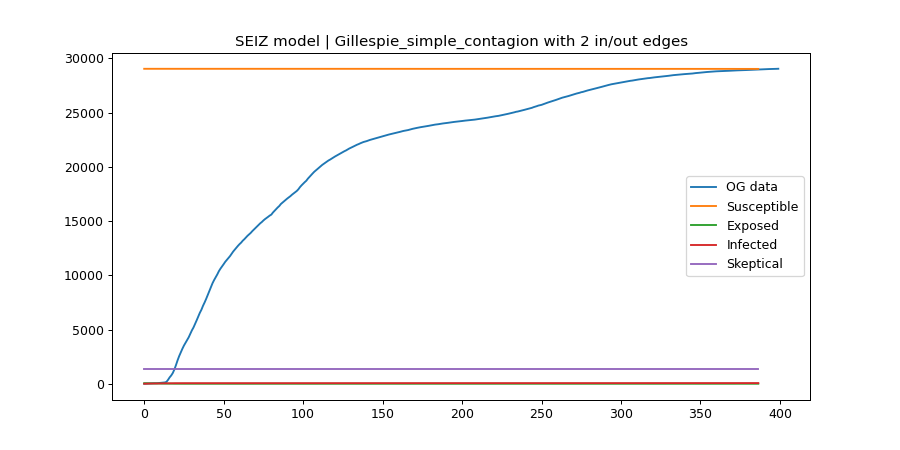

In [136]:
N = round(N)

print(beta)
# G = nx.fast_gnp_random_graph(N, 2./(N-1))

G = nx.directed_configuration_model(in_degrees, out_degrees)
G.remove_edges_from(nx.selfloop_edges(G))

H = nx.DiGraph()

# H.add_node('S')

H.add_edge('E', 'I', rate = e)

J = nx.DiGraph()
J.add_edge(('I', 'E'), ('I', 'I'), rate = ro)

J.add_edge(('I', 'S'), ('I', 'I'), rate = beta * p)
J.add_edge(('I', 'S'), ('I', 'E'), rate = beta * (1 - p))


J.add_edge(('Z', 'S'), ('Z', 'Z'), rate = beta * l)
J.add_edge(('Z', 'S'), ('Z', 'E'), rate = beta * (1 - l))


IC = defaultdict(lambda: 'S')

for node in range(round(E0)):
    IC[node] = 'E'
    
for node in range(round(I0)):
    IC[node + round(E0)] = 'I'

for node in range(round(Z0)):
    IC[node + round(E0 + I0)] = 'Z'

return_statuses = ('S', 'E', 'I', 'Z')

t, S, E, I, Z = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses,
                                        tmax = 400)

plt.figure(figsize=(10, 5))
plt.title('SEIZ model | Gillespie_simple_contagion with 2 in/out edges')
plt.plot(yData, label = 'OG data')
plt.plot(t, S, label = 'Susceptible')
plt.plot(t, E, label = 'Exposed')
plt.plot(t, I, label = 'Infected')
plt.plot(t, Z, label = 'Skeptical')
plt.legend()

plt.show()

# plt.savefig('SEIR.png')

In [17]:
N

28920

In [18]:
E0

7270.397490027181

In [19]:
Z0

650.9656814714043

In [20]:
I0

2.0

In [9]:
N

28919.693981450426

In [33]:
beta

1.2120422779513151e-06

In [28]:
beta

6.060211389756576e-07

In [17]:
N

28919.693981450426

In [34]:
0.017525945885466056 / 28919

6.06035681920746e-07

In [68]:
beta

0.05610427446993651

In [141]:
np.array(in_degrees).sum() + np.array(out_degrees).sum()

833250

In [142]:
N

30474.28654051972

In [73]:
round(N)

21765

In [132]:
833250 / 21765

38.28394210889042

In [134]:
0.00010059738438353401 / 38


2.6472995890403685e-06